Evaluate if k-mer based initialization of profiles on simulated data\* always leads to "true" k-mers being included, i.e. if profiles have a chance to get found by the model.  
Also try if spaced seeds work better in case k-mers fail  

\* Simulated data: 110kbp "unconserverd" sequence, 140bp "gene" in between; count all k-mers and apply lower occurrence threshold < num_sequences, want at least one k-mer that occurs in every gene

In [1]:
! pip install pyvolve

In [2]:
! pip install plotly

In [3]:
import plotly.io as pio
pio.renderers.default = "iframe"

In [4]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import scipy.stats
import tensorflow as tf
import logomaker
from time import time
from tqdm import tqdm
from IPython.display import Audio

import sys
sys.path.insert(0, 'modules/')
import importlib
import sequtils as su
print(importlib.reload(su))
import seq
print(importlib.reload(seq))
import dataset as dsg
print(importlib.reload(dsg))
import model
print(importlib.reload(model))
import aadist
print(importlib.reload(aadist))
import initProfilesExperiment as ipe
print(importlib.reload(ipe))


#sys.path.insert(0, '../../Software/GeneLinkDraw/')
#sys.path.insert(0, '../../Software/MSAgen/')
sys.path.insert(0, 'modules/GeneLinkDraw/')
sys.path.insert(0, 'modules/MSAgen/')
import geneLinkDraw as gld
print(importlib.reload(gld))
import MSAgen
print(importlib.reload(MSAgen))

print(tf.__version__)

%load_ext memory_profiler

<module 'sequtils' from 'modules/sequtils.py'>
<module 'seq' from 'modules/seq.py'>
<module 'dataset' from 'modules/dataset.py'>
<module 'model' from 'modules/model.py'>
<module 'aadist' from 'modules/aadist.py'>
<module 'initProfilesExperiment' from 'modules/initProfilesExperiment.py'>
<module 'geneLinkDraw' from 'modules/GeneLinkDraw/geneLinkDraw.py'>
<module 'MSAgen' from 'modules/MSAgen/MSAgen.py'>
2.5.0


In [5]:
N = 8
seqlen = 110000
genelen = 140
coding_dist=0.05
noncoding_dist=0.1
tree='star'
omega=0.4
midK = 6
occThreshold = N

hist = None

In [6]:
class kmerOccurrence:
    def __init__(self, g, c, pos):
        self.genome = g
        self.contig = c
        self.pos = pos

In [7]:
def drawLinkImage(genomes, links, posDict):
    drawGenes = []
    for g in range(len(genomes)):
        for c in range(len(genomes[g])):
            dg = gld.Gene(str(g)+"_"+str(c), str(g), len(genomes[g][c]), "+")
            drawGenes.append(dg)

    for dgene in drawGenes:
        dgene.addElement("gene", posDict['start_codon'], posDict['stop_codon']+2)

    # create links to draw
    drawLinks = []
    for link in links:
        lgenes = []
        lpos = []
        for occ in link:
            #gid = str(occ[0])+"_"+str(occ[1])
            gid = str(occ.genome)+"_"+str(occ.contig)
            lgenes.append(gid)
            #lpos.append(occ[2])
            lpos.append(occ.pos)

        drawLinks.append(gld.Link(lgenes, lpos))

    img, geneToCoord = gld.draw(drawGenes, drawLinks, font = "/opt/conda/fonts/Ubuntu-M.ttf",
                                genewidth = 20, linkwidth = 1, width = (1920*2))
    #img.save("links.png")

In [13]:
def kmerMidpoint(i,k):
    m = i + (k//2)
    return m



def sitesToLinks(sites, linkThreshold = 100, kmer=""):
    # sites == [[occ0.0, occ0.1, ...], [occ1.0, ...], ...]
    links = []
    nlinks = np.prod([len(og) for og in sites])
    if nlinks > linkThreshold:
        prodstr = ' * '.join([str(len(og)) for og in sites])
        print("[DEBUG] >>> "+kmer+" would produce", nlinks, "links ("+prodstr+"), skipping")
        return None
        
    l = list(itertools.product(*sites))
    links.extend(l)

    return links



def findGeneSpanningKmer(occs, posDict, returnLink = False, kmer=""):
    # separate occs after genome
    genomeOccs = [[] for _ in range(N)]
    for occ in occs:
        assert occ.contig == 0, "[ERROR] >>> Currently not able to run on genomes with > 1 sequence/contig"
        genomeOccs[occ.genome].append(occ)
    
    # if not all genomes covered, we're done
    if not all([len(o) for o in genomeOccs]):
        return False if not returnLink else None
    
    # check if there is an occurrence inside the CDS in all genomes
    a = posDict['cds_start']
    b = a + posDict['cds_len'] - 1
    linkOccs = None if not returnLink else [[] for _ in range(N)]
    for go in genomeOccs:
        # as soon as one genome is found that has no occurrence inside CDS, we're done
        if not any([occ.pos >= a and occ.pos <= b for occ in go]):
            return False if not returnLink else None
        
        if returnLink:
            o = np.array(go)
            i = [occ.pos >= a and occ.pos <= b for occ in o]
            linkOccs[o[0].genome].extend(list(o[i])) # store occurrences inside CDS
        
    # at least one occurrence per genome that is inside CDS
    if not returnLink:
        return True
    
    else:
        # create links inside CDS
        return sitesToLinks(linkOccs, kmer=kmer)



def checkKmers(draw=False, history=None, verbose=True):
    """ Perform the check
        Parameters:
            draw: boolean, if True, create a genome-link-image with the found links inside CDS (if any)
            history: genome list from previous run, to optionally check if new generated sequences are different 
    """
    
    # new set of simulated sequences
    sequences, posDict = MSAgen.generate_sequences(N, seqlen, genelen, coding_dist=coding_dist, noncoding_dist=noncoding_dist, tree=tree, omega=omega)
    genomes = [[str(seq.seq)] for seq in sequences]
    if history is not None:
        assert genomes[0][0] != history[0][0], "Same sequences generated"
        
    # vvv [ATTENTION] -- DEBUG vvv
    #print("[DEBUG] >>> posDict:", posDict)
    #for g in range(N):
    #    genomes[g][0] = 'N'*len(genomes[g][0])
    #for g in range(N):
    #    genomes[g][0] = genomes[g][0][:posDict['cds_start']]+("A"*3*midK)+genomes[g][0][posDict['cds_start']+midK:]
    # ^^^ [ATTENTION] -- DEBUG ^^^
    
    # count kmers and store their occurrences
    kmerOccs = {}
    for g in range(len(genomes)):
        for c in range(len(genomes[g])):
            sft = su.six_frame_translation(genomes[g][c])
            for f in range(len(sft)):
                seq = sft[f]
                for i in range(len(seq)-midK+1):
                    kmer = seq[i:i+midK]
                    if (' ' not in kmer):
                        if kmer not in kmerOccs:
                            kmerOccs[kmer] = []

                        aapos = kmerMidpoint(i,midK)
                        dnapos = su.convert_six_frame_position(aapos, f, len(genomes[g][c]), dna_to_aa=False)
                        kmerOccs[kmer].append(kmerOccurrence(g,c,dnapos))
                        
    kmers = [kmer for kmer in kmerOccs if len(kmerOccs[kmer]) >= occThreshold]
    if verbose:
        print("[INFO] >>> k =", midK, "-- threshold =", occThreshold, "-- Number of kmers:", len(kmers))
        
    # check if selected kmers contain an all-gene-spanning kmer
    contained = 0
    links = []
    for kmer in kmers:
        found = findGeneSpanningKmer(kmerOccs[kmer], posDict, returnLink=draw, kmer=kmer)
        if found:
            contained += 1
            
        if draw and found is not None:
            links.extend(found)
            
    if draw:
        drawLinkImage(genomes, links, posDict)
        
    return contained, genomes

[INFO] >>> k = 6 -- threshold = 8 -- Number of kmers: 175


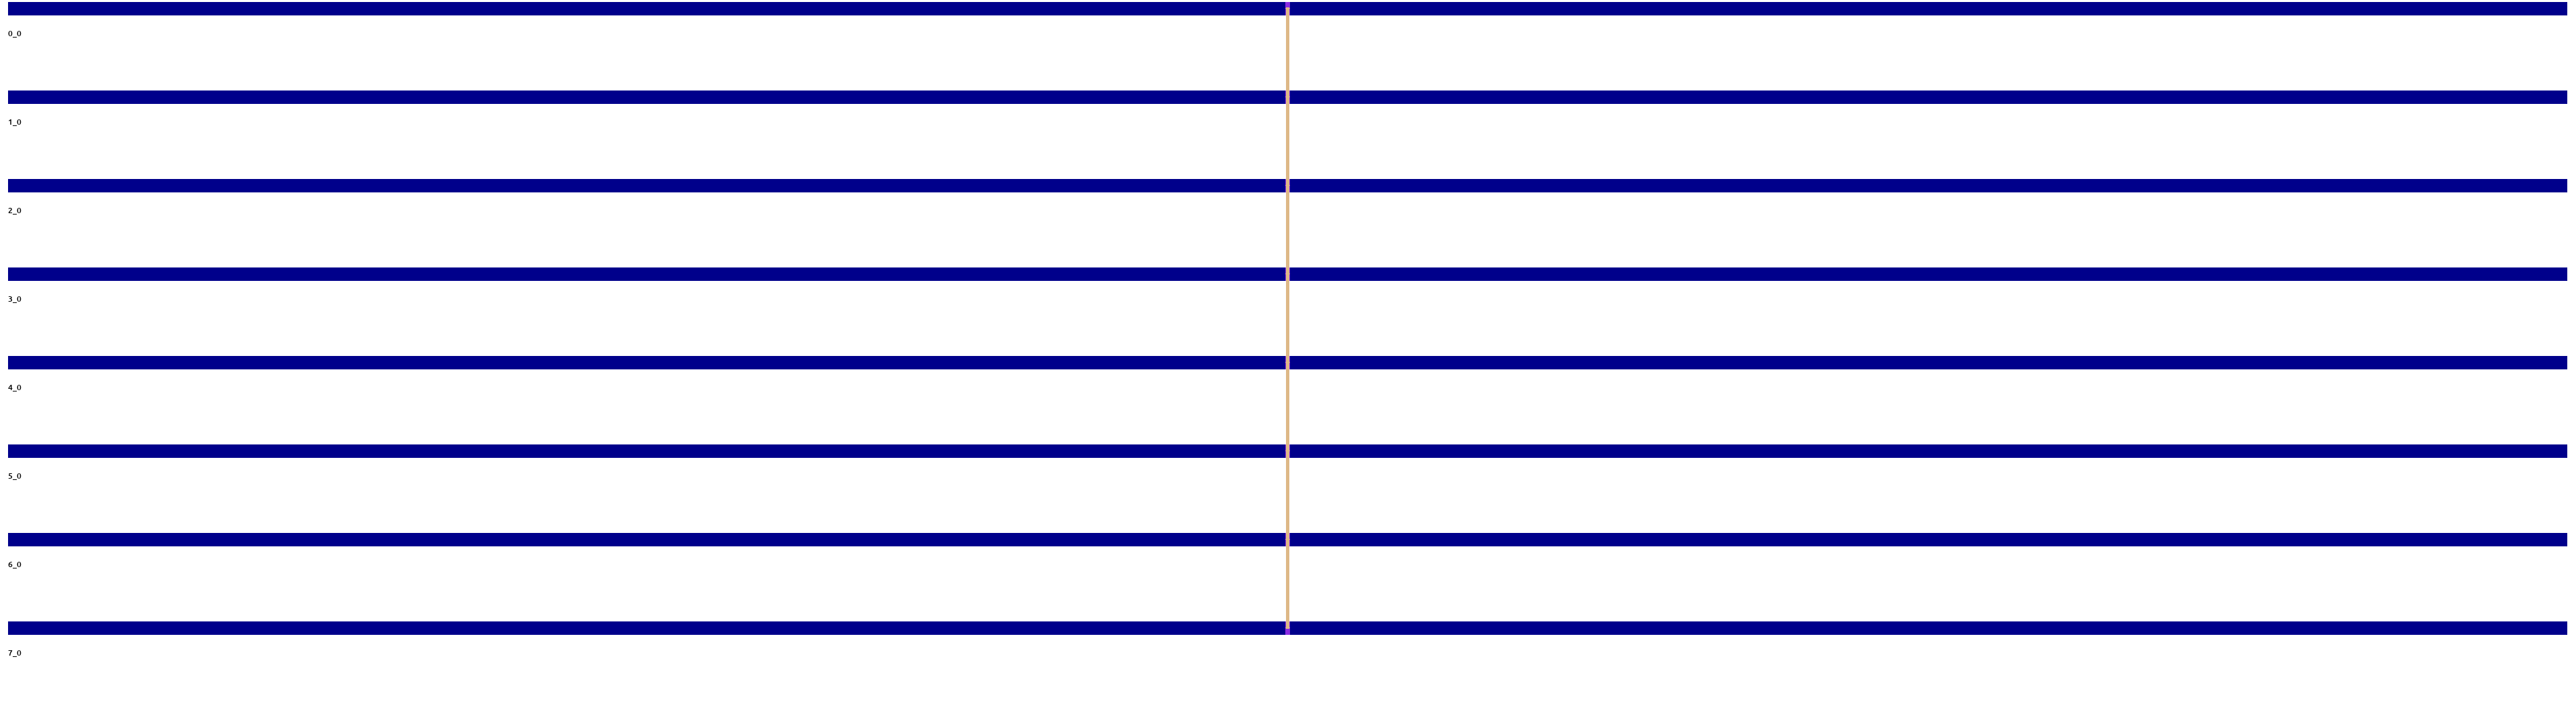

44 kmers contained in all CDS


In [14]:
contained, hist = checkKmers(draw=True, history=hist)
print(contained, "kmers contained in all CDS")